# SAML11 Data Capture via J-Link

Connecting via pylink:

1. Connect dev board, J-Trace, etc.
1. Open Atmel Studio and upload code using the dev board debugger (not the external J-Trace)
1. Open Ozone and connect via the J-Trace
1. Begin running the cells

If Ozone's debug session stops after running the jlink.open, jlink.connect. Restart the kernel and reconnect via ozone, then repeat. Try capturing a small number of traces to start, just to make sure capture works.

In [0]:
import time
import binascii

def get_key(key):
    """Send a key to the device"""
    string = ("k" + binascii.hexlify(key).decode("latin-1") + "\n").encode()
    print(string)
    jlink.rtt_write(0,string)
    
def do_multi_enc(seed):
    """Perform multiple encryptions, where input is randomly generated based on seed"""
    jlink.rtt_write(0,("m" + binascii.hexlify(seed).decode("latin-1") + "\n").encode())
    
def get_multi_trace():
    """Get result of multiple encryptions"""
    resp = ""
    jlink.rtt_write(0, "t\n".encode())
    while len(resp) < 2*64*32:
        resp += bytearray(jlink.rtt_read(0, 256*15+2)).decode('latin-1')
    return resp

def get_multi_ct():
    """Get output CT of multiple encryptions to check things are working"""
    resp = ""
    jlink.rtt_write(0, "c\n".encode())
    while len(resp) < 16*32:
        resp += bytearray(jlink.rtt_read(0, 256*15+2)).decode('latin-1')
    return resp

In [0]:
# Following functions are used to generate the PT used for the AES attack. To save
# B/W the PT is generated on-board using a simple LFSR. This replicates the LFSR
# that is present on the microcontroller.

state = 0
def xorshift32():
    global state
    x = state
    x ^= (x << 13) & 0xFFFFFFFF
    x ^= (x >> 17) & 0xFFFFFFFF
    x ^= (x << 15) & 0xFFFFFFFF
    state = x & 0xFFFFFFFF;
    return x;

def u32_to_bytes(u32):
    return [u32 & 0xFF, (u32 >> 8) & 0xFF, (u32 >> 16) & 0xFF, (u32 >> 24) & 0xFF]

def bytes_to_u32(byte):
    return byte[0] | (byte[1] << 8) | (byte[2] << 16) | (byte[3] << 24)

def set_seed(seed):
    global state
    state = seed
def get_pt_from_xor():
    ret = []
    for i in range(4):
        val = xorshift32()
        ret.extend(u32_to_bytes(val))
    return bytearray(ret)

In [0]:
import pylink
jlink = pylink.JLink()
jlink.MAX_JTAG_SPEED=50000
jlink.open()
jlink.set_tif(pylink.enums.JLinkInterfaces.SWD)
jlink.connect("ATSAML11E16A", speed = 15000)
#jlink.flash_file("C:\\Users\\User\\Documents\\Atmel Studio\\7.0\\M23_ADC\\M23_ADC\\Debug\\M23_ADC.hex", 0)
jlink.rtt_start()

In [0]:
trace_list = []
ct_list = []

In [0]:
seed = bytearray([0xDE, 0xAD, 0xBE, 0xEF])
do_multi_enc(seed)

In [0]:
import chipwhisperer as cw
from tqdm import tnrange
from chipwhisperer.capture.acq_patterns.basic import AcqKeyTextPattern_Basic
from chipwhisperer.capture.acq_patterns.tvlattest import AcqKeyTextPattern_TVLATTest
import numpy as np
import binascii

The following cell will perform a short capture. It can be used to validate that the connection is all OK.

In [0]:
import chipwhisperer as cw
import numpy as np
import binascii
from tqdm import tnrange
N = 10
#jlink.reset(halt=False)
seed = bytearray([0xDE, 0xAD, 0xBE, 0xEF])
do_multi_enc(seed)
traces = get_multi_trace()
cts = get_multi_ct()
time.sleep(0.01)

ktp = cw.ktp.Basic()
ktp.initPair(N)
#ktp.setKeyType(False)

trace_range = range(30, 34) #attack traces 30 to 33

trace_array = np.zeros( (N*32, len(trace_range)), dtype="uint16")
textin_array = np.zeros( (N*32, 16), dtype="uint8" )
textout_array = np.zeros( (N*32, 16), dtype="uint8" )
key_sent = False
real_key = 0


for k in tnrange(N):
        
    #jlink.reset(halt=False)
    #time.sleep(0.01)
    key, text = ktp.newPair()
    real_key=key
    if not key_sent:
        get_key(key)
    key_sent = True
        
    seed = text[0:4]
    #seed = bytearray([0xDE, 0xAD, 0xBE, 0xEF])
    set_seed(bytes_to_u32(seed))
    do_multi_enc(seed)
    traces = get_multi_trace()
    cts = get_multi_ct()


    for i in range(32):
        tmp = traces[i*2*64:(i+1)*2*64 - 2]
        textin_array[k*32+i] = bytearray(get_pt_from_xor() )
        #set_seed(bytes_to_u32(seed))
        textout_array[k*32+i] = bytearray(cts[i*16:(i+1)*16].encode("latin-1"))
        trace = [0] * 63
        for j in trace_range:
            trace_array[k*32+i][j-trace_range[0]] = ord(tmp[j*2]) | (ord(tmp[j*2 + 1]) << 8)
            #trace[j] = ord(tmp[j*2]) | (ord(tmp[j*2 + 1]) << 8)
        
        #tc.addTrace(trace, pt, ct, key)
        #trace_list.append(trace)
        #ct_list.append(trace)
    


b'k2b7e151628aed2a6abf7158809cf4f3c\n'


The following performs a large capture. Basicallly you can specify num_files, where each file will have N*32 traces. So for example 150 files x 50000 captures/file x 32 traces/capture = 240M individual encryption operations.

Note that 32 encryptions are done PER "trace"! This is done to speed up our capture process.

You currently need to manually specify the base filename (i.e., no_shunt_...) in each of the numpy files!

In [0]:
# Capture loop that saves to numpy arrays
import chipwhisperer as cw
import numpy as np
import binascii
from tqdm import tnrange
N = 50000
#jlink.reset(halt=False)
seed = bytearray([0xDE, 0xAD, 0xBE, 0xEF])
do_multi_enc(seed)
traces = get_multi_trace()
cts = get_multi_ct()
time.sleep(0.01)

ktp = cw.ktp.Basic()
ktp.initPair(N)
#ktp.setKeyType(False)

trace_range = range(30, 34) #attack traces 30 to 33


key_sent = False
real_key = 0

num_files = 150
for f in tnrange(0, num_files, desc="Num file"):
    trace_array = np.zeros( (N*32, len(trace_range)), dtype="uint16")
    textin_array = np.zeros( (N*32, 16), dtype="uint8" )
    textout_array = np.zeros( (N*32, 16), dtype="uint8" )
    for k in tnrange(N, desc="Trace (set of 32)", leave=False):

        #jlink.reset(halt=False)
        #time.sleep(0.01)
        key, text = ktp.newPair()
        real_key=key
        if not key_sent:
            get_key(key)
        key_sent = True

        seed = text[0:4]
        #seed = bytearray([0xDE, 0xAD, 0xBE, 0xEF])
        set_seed(bytes_to_u32(seed))
        do_multi_enc(seed)
        traces = get_multi_trace()
        cts = get_multi_ct()


        for i in range(32):
            tmp = traces[i*2*64:(i+1)*2*64 - 2]
            textin_array[k*32+i] = bytearray(get_pt_from_xor() )
            #set_seed(bytes_to_u32(seed))
            textout_array[k*32+i] = bytearray(cts[i*16:(i+1)*16].encode("latin-1"))
            trace = [0] * 63
            for j in trace_range:
                trace_array[k*32+i][j-trace_range[0]] = ord(tmp[j*2]) | (ord(tmp[j*2 + 1]) << 8)
                
    np.save(f"no_shunt_trace_array_{f}", trace_array)
    np.save(f"no_shunt_textin_array_{f}", textin_array)
    np.save(f"no_shunt_textout_array_{f}", textout_array)
    del trace_array
    del textin_array
    del textout_array
            

np.save(f"no_shunt_key", real_key)

b'k2b7e151628aed2a6abf7158809cf4f3c\n'


Run the following cell to view plots of the various traces. You should run this for example after running the short capture cell.

<IPython.core.display.Javascript object>


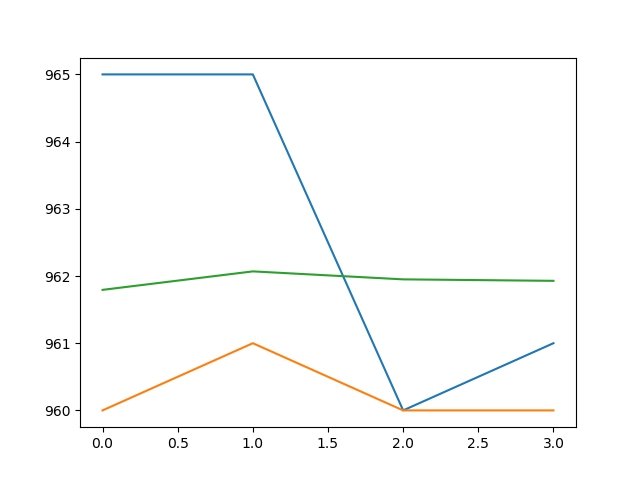

In [0]:
%matplotlib notebook
import matplotlib.pyplot as  plt
mean = np.average(trace_array, axis=0)
plt.plot(trace_array[80])
plt.plot(trace_array[71])
#plt.plot(project.traceManager().getTrace(2))
#plt.plot(project.traceManager().getTrace(3))
#plt.plot(project.traceManager().getTrace(4))
#plt.plot(trace_array[14000])
#plt.plot(project.traceManager().getTrace(0))
plt.plot(mean)
#plt.plot(project.traceManager().getTrace(120))
#plt.plot(project.traceManager().getTrace(180))
plt.show()

In [0]:
from Crypto.Cipher import AES
cipher = AES.new(real_key, AES.MODE_ECB)
expected_ct = cipher.encrypt(bytearray(textin_array[5]))
print(binascii.hexlify(bytearray(textout_array[5])))
print(binascii.hexlify(bytearray(expected_ct)))